In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
import seaborn as sns
import csv
import re
from matplotlib import pyplot as plt
from sklearn import ensemble, cross_validation, learning_curve, metrics , tree, naive_bayes
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_digits, load_breast_cancer
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans, AgglomerativeClustering, FeatureAgglomeration
matplotlib.style.use('ggplot')
%matplotlib inline

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Скачаем любым удобным образом архив fsp.zip с этой страницы.

Нас будет интересовать файл checkins.dat. Открыв его, увидим следующую структуру:


In [27]:
with open('./checkins.dat') as dat_file:
    name_columns = dat_file.readline().split('|')
    name_columns = [name_columns[i].strip() for i in range(len(name_columns))]
    response_table = []
    response_table.append(name_columns)
    cnt_columns = len(name_columns)
    i = 0
    for line in dat_file:
        response_line = line.split('|')
        if len(response_line) == cnt_columns:
            response_line = [response_line[i].strip() for i in range(len(response_line))]
            flag = True
            for elem in response_line:
                if len(elem) == 0:
                    flag = False
            if flag:
                response_table.append(response_line)
    print(len(response_table))

396635


Для удобной работы с этим документом преобразуем его к формату csv, удалив строки, не содержащие координат — они неинформативны для нас:

С помощью pandas построим DataFrame и убедимся, что все 396634 строки с координатами считаны успешно.

In [59]:
df = pd.DataFrame(response_table[:][1:], columns=response_table[:][0])
print(df.shape, df.head(), sep='\n')

(396634, 6)
       id  user_id venue_id    latitude     longitude           created_at
0  984222    15824     5222  38.8951118   -77.0363658  2012-04-21 17:43:47
1  984234    44652     5222   33.800745     -84.41052  2012-04-21 17:43:43
2  984291   105054     5222  45.5234515  -122.6762071  2012-04-21 17:39:22
3  984318  2146539     5222   40.764462   -111.904565  2012-04-21 17:35:46
4  984232    93870   380645  33.4483771  -112.0740373  2012-04-21 17:38:18


In [61]:
latitude = df['latitude'].values
longitude = df['longitude'].values

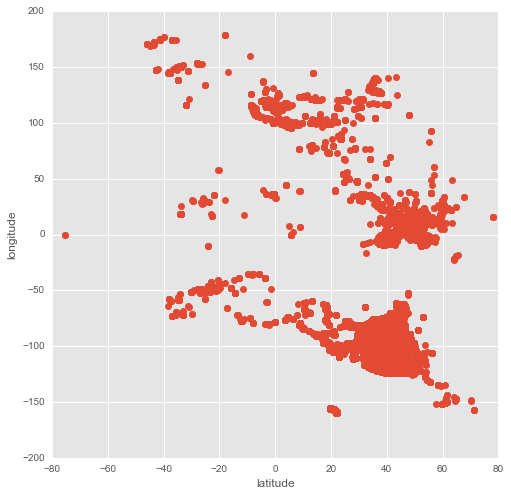

In [63]:
plt.figure(figsize=(8,8))
plt.plot(latitude, longitude, 'o')
plt.xlabel('latitude')
plt.ylabel('longitude')

Теперь необходимо кластеризовать данные координаты, чтобы выявить центры скоплений туристов. Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров.

Эта задача — хороший повод познакомиться с алгоритмом MeanShift, который мы обошли стороной в основной части лекций. Его описание при желании можно посмотреть в sklearn user guide, а чуть позже появится дополнительное видео с обзором этого и некоторых других алгоритмов кластеризации. Используйте MeanShift, указав bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

Примечание: на 396634 строках кластеризация будет работать долго. Быть очень терпеливым не возбраняется — результат от этого только улучшится. Но для того, чтобы сдать задание, понадобится сабсет из первых 100 тысяч строк. Это компромисс между качеством и затраченным временем. Обучение алгоритма на всём датасете занимает около часа, а на 100 тыс. строк — примерно 2 минуты, однако этого достаточно для получения корректных результатов.

Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

При желании увидеть получившиеся результаты на карте можно передать центры получившихся кластеров в один из инструментов визуализации. Например, сайт mapcustomizer.com имеет функцию Bulk Entry, куда можно вставить центры полученных кластеров в формате:


Как мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на Google Maps по запросу Carnival Cruise Line адреса офисов:


Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

Примечание: при подсчете расстояний и в кластеризации можно пренебречь тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико.

Для сдачи задания выберите из получившихся 20 центров тот, который наименее удален от ближайшего к нему офиса. Ответ в этом задании — широта и долгота этого центра, записанные через пробел.




In [76]:
subset = df[['latitude', 'longitude']]
subset = subset.applymap(float).sample(100000)
print(subset)

         latitude   longitude
205249  39.953729  -74.197919
3392    33.414768 -111.909310
135790  33.370320 -112.583777
331767  32.715329 -117.157255
5646    42.088360  -87.980626
174552  29.894264  -81.313208
93941   43.038902  -87.906474
258197  35.227087  -80.843127
73689   40.037391  -83.000585
87968   40.650000  -73.950000
367010   3.092563  101.599292
338208  40.740389  -73.983385
251081  40.911488  -73.782355
295699  39.708542  -74.267652
178442  40.650000  -73.950000
255135  40.715972  -74.001437
143083  32.981212 -117.078863
239180  37.322998 -122.032182
394692  41.878114  -87.629798
33538   34.391664 -118.542586
24326   40.714353  -74.005973
58330   45.523452 -122.676207
158440  41.162873  -73.861525
73244   41.850028  -88.312574
103764  33.493374 -112.357936
301149  41.878114  -87.629798
373864  41.878114  -87.629798
134086  40.177889  -74.583489
102253  42.331764  -71.121163
111146  33.448377 -112.074037
...           ...         ...
183197  38.879970  -77.106770
361937  44

In [79]:
import warnings
warnings.filterwarnings("ignore")

In [80]:
%%time
from sklearn.cluster import MeanShift
clst = MeanShift(bandwidth=0.1, n_jobs=-1)
clst.fit(subset)

CPU times: user 16.4 s, sys: 492 ms, total: 16.9 s
Wall time: 29.7 s


In [93]:
cnt_dict = {}
number_of_clusters = clst.predict(subset)
for number_cluster in number_of_clusters:
    if number_cluster in cnt_dict:
        cnt_dict[number_cluster] += 1
    else:
        cnt_dict[number_cluster] = 0
response_clusters = []
for number_cluster in cnt_dict:
    if cnt_dict[number_cluster] > 15:
        response_clusters.append(number_cluster)

cluster_centres = clst.cluster_centers_[response_clusters]
print(cluster_centres)

[[ 40.71705775 -73.98920542]
 [ 41.87818404 -87.62984016]
 [ 38.88658002 -77.04775113]
 ..., 
 [ 39.70333098 -74.97833808]
 [ 39.7285768  -75.28506637]
 [ 44.7132969  -93.4227274 ]]


In [109]:
office_coordinates = [
    [33.751277, -118.188740],
    [25.867736, -80.324116],
    [51.503016, -0.075479],
    [52.378894, 4.885084],
    [39.366487, 117.036146],
    [-33.868457, 151.205134],
]

def min_distance (lati, long):
    dist = [((lati - cord_office[0])** 2 + (long - cord_office[1])**2)**(1./2) for cord_office in office_coordinates]
    return min(dist)

In [119]:
dist_and_clusters = []
for cluster in cluster_centres:
    min_distance(cluster[0], cluster[1])
    dist_and_clusters.append([min_distance(cluster[0], cluster[1]), cluster[0], cluster[1]])
print(sorted(dist_and_clusters)[0][1:])

[-33.865953186792417, 151.20629925094354]


In [4]:
#write answer to csv
#получаем csv файл, 
# где 
#1)i-ый элемент 1-ого столбца - номер ответа на i-ом объекте, начиная с 1
#2)i-ый элемент 2-ого столбца - ответ на i-ом объекте
def write_answer_to_csv(y_pred, file_name='my_submission.csv'):
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['ImageId', 'Label'])
        for i in range(y_pred.shape[0]):
            writer.writerow([i+1, y_pred[i]])